<p align="center">
  <font size="6">Airbnb Analysis</font><br>
</p>

---

> This notebook contains an analysis of Airbnb data, and is focused on answering three important business-related questions:

> 1. How does location and room type affect the cost of the room?
> 2. How does availability over the next year correlate to room type and location?
> 3. What is the distribution of listings between hosts and property types?


## Data imports
---

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Dataset handling
---
This section contains code focused on addressing null records in the dataframe. As a rule, these will not be dropped but will, instead, be transformed so that they may still offer some business value.

In [ ]:
# Load the new Airbnb dataset with data from New York in 2019
ab_nyc_df = pd.read_csv("AB_NYC_2019.csv")

ab_nyc_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
ab_nyc_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Data preprocessing
---

In [ ]:
# Get total dataset size
len(ab_nyc_df)

48895

In [ ]:
# Count null total null records across the entire dataframe
ab_nyc_df.isnull().sum().sum()

20141

In [ ]:
# Get the proportion of null records
total_null_records = ab_nyc_df.isnull().sum().sum()
df_size = len(ab_nyc_df)

print(f"Proportion of null records: {total_null_records/df_size * 100}")

Proportion of null records: 41.19235095613048


In [ ]:
# Count null values per column
ab_nyc_df.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
# Replace the null values in the appropriate columns
# Starting with name and host name, we'll replace "NaN" with "Unknown"
ab_nyc_df["name"].fillna("Unknown", inplace = True)
ab_nyc_df["host_name"].fillna("Unknown", inplace = True)

# Next, we'll replace null values in last_review and reviews_per_month
# Records having "NaN" as last_review values means that they've never been visited
# Similarly, "NaN" reviews_per_month values means that, as these hosts have never been visited, this value has to be 0
ab_nyc_df["last_review"].fillna("Never", inplace = True)
ab_nyc_df["reviews_per_month"].fillna(0, inplace = True)

<ipython-input-82-7a4c2f30bdb9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ab_nyc_df["name"].fillna("Unknown", inplace = True)
<ipython-input-82-7a4c2f30bdb9>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

In [ ]:
# Count null values per column
ab_nyc_df.isnull().sum()

,0
id,0
name,0
host_id,0
host_name,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [ ]:
# Before conducting any analyses, it's important to map the categorical columns to a numerical format
# Define categorical columns to map
categorical_columns = ["name", "host_name", "neighbourhood_group", "neighbourhood", "room_type", "last_review"]

# Copy the existing dataframe to an analysis-specific one
ab_nyc_df_analysis = ab_nyc_df.copy()

# Define reverse mappings dictionary
reverse_mappings = {}

# Apply a map to the categorical values
for col in categorical_columns:
  unique_vals = ab_nyc_df_analysis[col].unique()
  mapping = {val: i + 1 for i, val in enumerate(unique_vals)}
  reverse_mapping = {v: k for k, v in mapping.items()}
  ab_nyc_df_analysis[col] = ab_nyc_df[col].map(mapping)
  reverse_mappings[col] = reverse_mapping

  # Print the mapping for each column
  print(f"Mapping for {col}:", mapping)

print("\n")

# Display the updated DataFrame
ab_nyc_df_analysis.head()

Mapping for name: {'Clean & quiet apt home by the park': 1, 'Skylit Midtown Castle': 2, 'THE VILLAGE OF HARLEM....NEW YORK !': 3, 'Cozy Entire Floor of Brownstone': 4, 'Entire Apt: Spacious Studio/Loft by central park': 5, 'Large Cozy 1 BR Apartment In Midtown East': 6, 'BlissArtsSpace!': 7, "Large Furnished Room Near B'way ": 8, 'Cozy Clean Guest Room - Family Apt': 9, 'Cute & Cozy Lower East Side 1 bdrm': 10, 'Beautiful 1br on Upper West Side': 11, 'Central Manhattan/near Broadway': 12, 'Lovely Room 1, Garden, Best Area, Legal rental': 13, 'Wonderful Guest Bedroom in Manhattan for SINGLES': 14, 'West Village Nest - Superhost': 15, 'Only 2 stops to Manhattan studio': 16, 'Perfect for Your Parents + Garden': 17, 'Chelsea Perfect': 18, 'Hip Historic Brownstone Apartment with Backyard': 19, 'Huge 2 BR Upper East  Cental Park': 20, 'Sweet and Spacious Brooklyn Loft': 21, 'CBG CtyBGd HelpsHaiti rm#1:1-4': 22, 'CBG Helps Haiti Room#2.5': 23, 'CBG Helps Haiti Rm #2': 24, 'MAISON DES SIRENES1

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,1,2787,1,1,1,40.64749,-73.97237,1,149,1,9,1,0.21,6,365
1,2595,2,2845,2,2,2,40.75362,-73.98377,2,225,1,45,2,0.38,2,355
2,3647,3,4632,3,2,3,40.80902,-73.94190,1,150,3,0,3,0.00,1,365
3,3831,4,4869,4,1,4,40.68514,-73.95976,2,89,1,270,4,4.64,1,194
4,5022,5,7192,5,2,5,40.79851,-73.94399,2,80,10,9,5,0.10,1,0


In [ ]:
# Sample dataframe containing neighbourhood group mappings
neighbourhood_group_mapping = pd.DataFrame({
    "neighbourhood_group": ["Brooklyn", "Manhattan", "Queens", "Staten Island", "Bronx"],
    "neighbourhood_group_id": [1, 2, 3, 4, 5]
})

neighbourhood_group_mapping.head()

,neighbourhood_group,neighbourhood_group_id
0,Brooklyn,1
1,Manhattan,2
2,Queens,3
3,Staten Island,4
4,Bronx,5


## Exploratory data analysis (EDA)
---
This section will be focused on an in-depth exploration of this dataset, using tools such as visualisation and correlation analysis to draw insights from the data.

### Distribution analysis
---

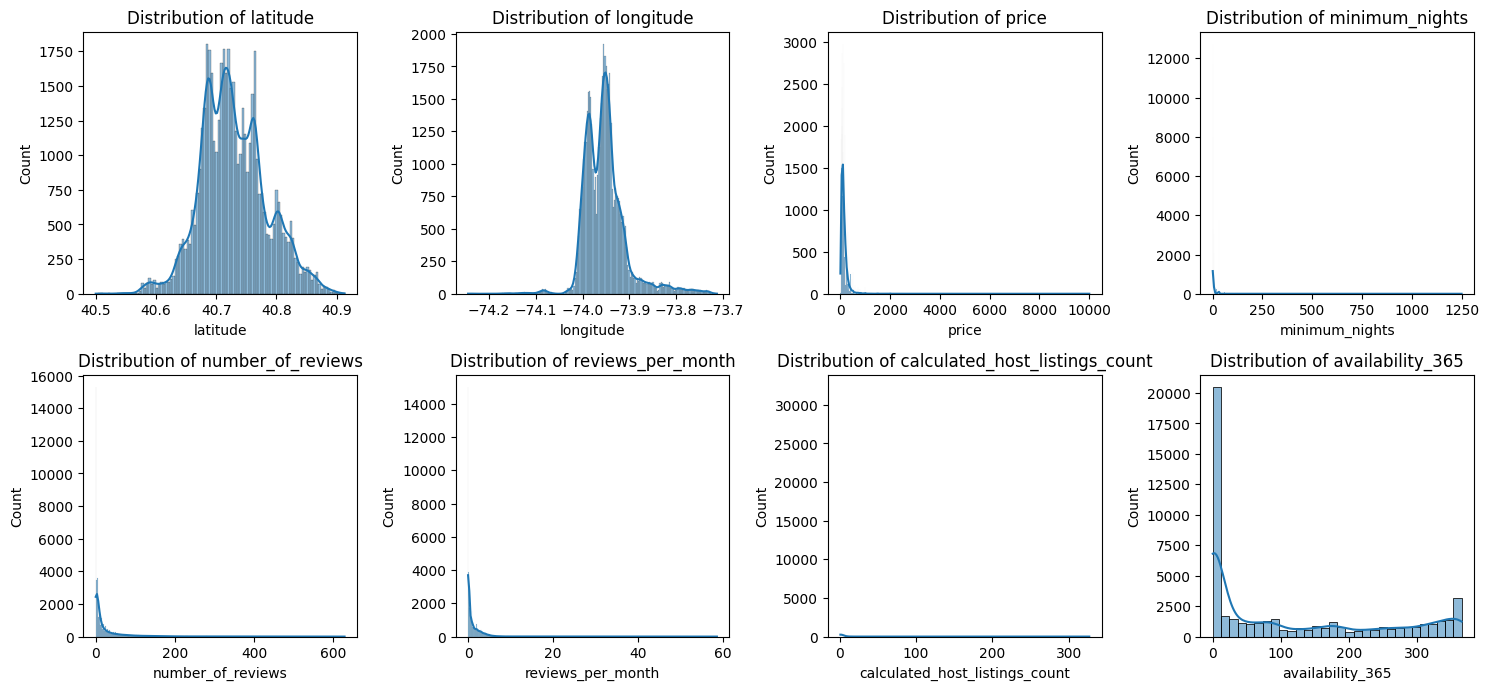

In [ ]:
# Select numerical columns
numerical_columns = ab_nyc_df_analysis.select_dtypes(include = ["int64", "float64"]).columns

# Exclude categorical mapped columns (ID columns as well)
continuous_numerical_columns = [col for col in numerical_columns if col not in categorical_columns and col not in ["id", "host_id"]]

# Set up the figure to create a grid of histograms
plt.figure(figsize = (15, 10))

# Loop over numerical columns and create a histogram for each
for i, col in enumerate(continuous_numerical_columns, 1):
  # Arrange in a grid with 4 columns
  plt.subplot(len(continuous_numerical_columns) // 4 + 1, 4, i)
  sns.histplot(ab_nyc_df_analysis[col], kde = True)
  plt.title(f"Distribution of {col}")

plt.tight_layout()

### Correlation analysis
---

In [ ]:
# One-hot encode nominal categorical columns
categorical_columns = ["neighbourhood_group", "room_type"]
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_categorical = encoder.fit_transform(ab_nyc_df_analysis[categorical_columns])

# Convert encoded columns to a DataFrame
encoded_categorical_df = pd.DataFrame(
    encoded_categorical,
    columns=encoder.get_feature_names_out(categorical_columns)
)

# Combine continuous features and encoded categorical features
combined_df = pd.concat(
    [ab_nyc_df_analysis[["price", "reviews_per_month", "availability_365"]], encoded_categorical_df],
    axis=1
)

# Initialize an empty DataFrame for the correlation matrix
correlation_matrix = pd.DataFrame(index=combined_df.columns, columns=combined_df.columns)

# Compute point-biserial correlation for binary vs continuous columns
for binary_col in encoded_categorical_df.columns:
    for continuous_col in ["price", "reviews_per_month", "availability_365"]:
        # Compute point-biserial correlation
        correlation, _ = pointbiserialr(combined_df[binary_col], combined_df[continuous_col])

        # Store the correlation value
        correlation_matrix.loc[binary_col, continuous_col] = correlation
        correlation_matrix.loc[continuous_col, binary_col] = correlation

# Fill diagonal with 1 (self-correlation)
for col in correlation_matrix.columns:
    correlation_matrix.loc[col, col] = 1

# Convert all entries to numeric type
correlation_matrix = correlation_matrix.astype(float)

# Rename columns with original categorical names (optional)
new_column_names = {}
for col in encoded_categorical_df.columns:
    for original_col in reverse_mappings:
        if original_col in col:
            suffix = int(col.split("_")[-1])
            if suffix in reverse_mappings[original_col]:
                new_column_names[col] = f"{original_col}: {reverse_mappings[original_col][suffix]}"
                break
    else:
        new_column_names[col] = col

correlation_matrix.rename(columns=new_column_names, index=new_column_names, inplace=True)

# Display the correlation matrix
correlation_matrix

,price,reviews_per_month,availability_365,neighbourhood_group: Brooklyn,neighbourhood_group: Manhattan,neighbourhood_group: Queens,neighbourhood_group: Staten Island,neighbourhood_group: Bronx,room_type: Private room,room_type: Entire home/apt,room_type: Shared room
price,1.000000,NaN,NaN,-0.098603,0.163976,-0.080205,-0.013840,-0.041030,-0.240246,0.255857,-0.053613
reviews_per_month,NaN,1.000000,NaN,-0.021512,-0.063723,0.107927,0.026648,0.036390,0.030178,-0.029565,-0.001714
availability_365,NaN,NaN,1.000000,-0.079671,-0.005434,0.087113,0.057885,0.060806,-0.010986,-0.006804,0.058294
neighbourhood_group: Brooklyn,-0.098603,-0.021512,-0.079671,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group: Manhattan,0.163976,-0.063723,-0.005434,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group: Queens,-0.080205,0.107927,0.087113,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
neighbourhood_group: Staten Island,-0.013840,0.026648,0.057885,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
neighbourhood_group: Bronx,-0.041030,0.036390,0.060806,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
room_type: Private room,-0.240246,0.030178,-0.010986,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
room_type: Entire home/apt,0.255857,-0.029565,-0.006804,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN


Text(0.5, 1.0, 'Correlation matrix')

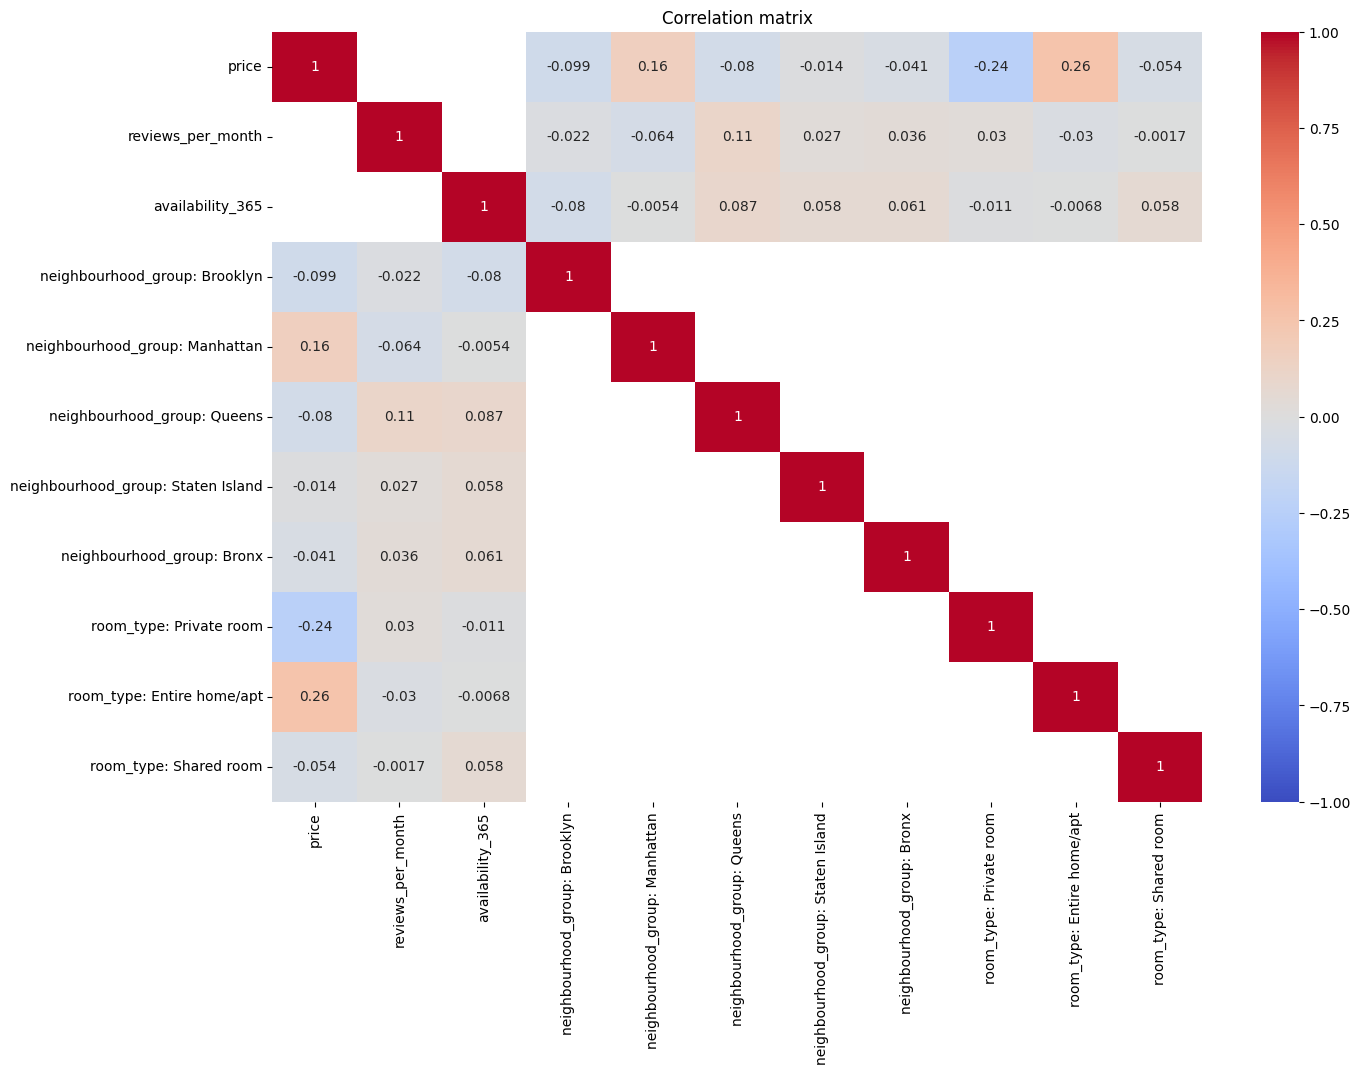

In [ ]:
# Create a heatmap for visualization
plt.figure(figsize = (15, 10))

sns.heatmap(
    correlation_matrix,
    annot = True,
    cmap = "coolwarm",
    vmin = -1,
    vmax = 1
)
plt.title("Correlation matrix")

### First business question: how does location and room type affect the cost of the room?
---
The correlation analysis section has shown that there is a small, positive correlation between neighbourhood_group and room_type, and a stronger positive relationship between room_type and price, which implies that there is a relationship between these variables. Interestingly, the relationship between neighbourhood_group and price, despite being positive, seems to be fairly weak, suggesting that location alone does not determine renting price.

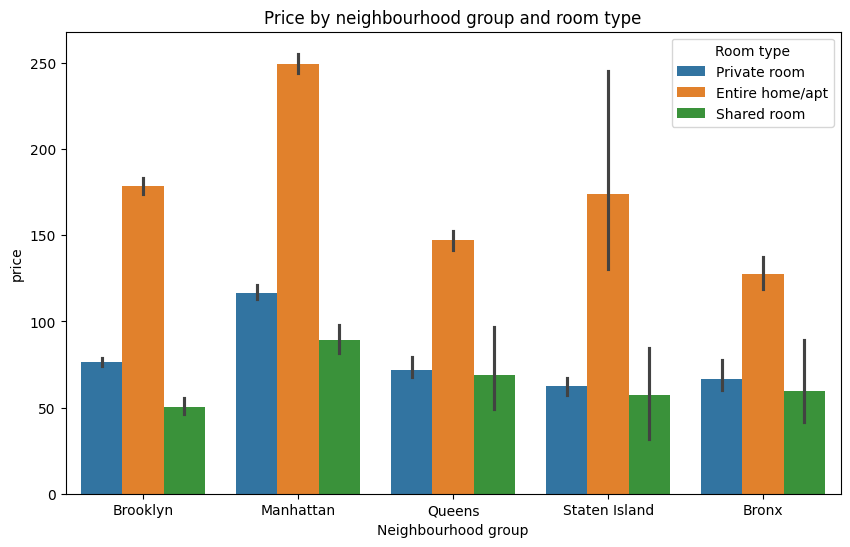

In [ ]:
# Create a scatter plot of neighbourhood_group, room_type and price
# We'll use the original dataset for the plot as it contains the original labels
plt.figure(figsize = (10, 6))
sns.barplot(data = ab_nyc_df, x = "neighbourhood_group", y = "price", hue = "room_type")
plt.title("Price by neighbourhood group and room type")
plt.xlabel("Neighbourhood group")
plt.legend(title = "Room type")

As can be seen, rental price is at its highest in the Manhattan area and for entire homes/apartments, which is expected. Interestingly, private and shared rooms in Queens, Staten Island and Bronx have similar prices. Although demand would be a safe assumption for this, additional analyses would be needed to determine what factors are driving such price similarities.

<ipython-input-50-294712842349>:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


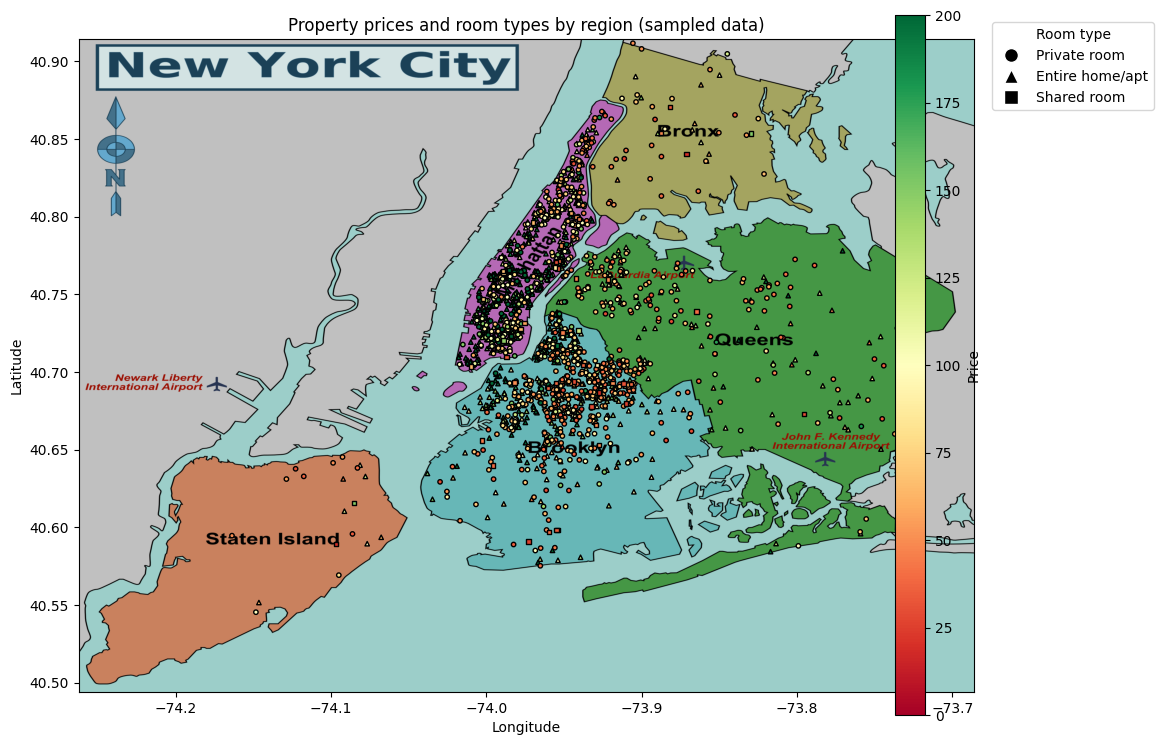

In [ ]:
# Define image size
plt.figure(figsize = (10, 10))

# Load and display map image
coordinates = (-74.2623, -73.6862, 40.4943, 40.9144)
map_img = mpimg.imread("nyc-borough-map.png")
plt.imshow(map_img, extent=coordinates)

# Sample 10000 data points
sampled_data = ab_nyc_df.sample(n=2000, random_state=1).reset_index(drop=True)

# Cap prices at 200
price_upper_limit = 200
sampled_data['price'] = sampled_data['price'].apply(lambda x: x if x <= price_upper_limit else price_upper_limit)

# Normalize price data for color mapping
prices = sampled_data['price']
norm_prices = (prices - prices.min()) / (prices.max() - prices.min())
colors = plt.cm.RdYlGn(norm_prices)

# Set marker styles based on room type
room_type_markers = {
    'Private room': 'o',
    'Entire home/apt': '^',
    'Shared room': 's'  # Added Shared room
}

# Plot property prices and room types on the map
sc = None
for room_type, group in sampled_data.groupby('room_type'):
    sc = plt.scatter(group['longitude'], group['latitude'], c=group['price'], cmap='RdYlGn',
                     edgecolors='black', marker=room_type_markers.get(room_type, 'o'), s=10,
                     label=room_type, norm=mcolors.Normalize(vmin=0, vmax=price_upper_limit))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Property prices and room types by region (sampled data)')

# Adjust subplot layout to position color bar on the right
fig = plt.gcf()
fig.subplots_adjust(right=0.75)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
plt.colorbar(sc, cax=cbar_ax, label='Price')

# Add legend
handles = [plt.Line2D([0], [0], marker=room_type_markers[rt], color='w', markerfacecolor='k', markersize=10, label=rt)
           for rt in room_type_markers]
plt.legend(handles=handles, title='Room type', loc='upper left', bbox_to_anchor=(3.0, 1))
plt.tight_layout()

### Second business question: how does availability over the next year correlate to room type and location?
---
The correlation analysis section has shown that there is a small, positive correlation between availability_365 and room_type, and a stronger positive relationship between room_type and price, as seen previously. Interestingly, the relationship between availability_365 and neighbourhood_group, despite being positive, seems to be fairly weak, suggesting that availability varies significantly between locations, as expected.

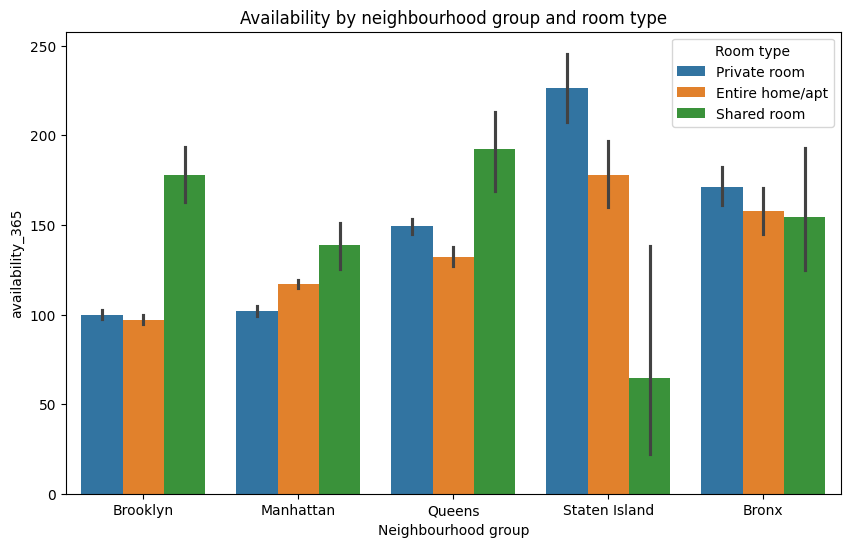

In [ ]:
# Create a scatter plot of neighbourhood_group, room_type and availability_365
# We'll use the original dataset for the plot as it contains the original labels
plt.figure(figsize = (10, 6))
sns.barplot(data = ab_nyc_df, x = "neighbourhood_group", y = "availability_365", hue = "room_type")
plt.title("Availability by neighbourhood group and room type")
plt.xlabel("Neighbourhood group")
plt.legend(title = "Room type")

This plot shows some interesting results. For instance, shared room availability is very low in Staten Island while private rooms are available for 200+ days in the next year. Manhattan and Brooklyn steal the spotlight as locations that show a general level of unavailability, with the sole exception being shared rooms in Brooklyn, which are available for 150+ days in the next year.

#### Clustering by availability
---
We can use a clustering approach to group our data based on availability, room type and neighbourhood group. The following clusters have been defined:

<br>

* **Cluster 0 (purple):** listings which are likely fully booked or have limited availability, possibly being the most popular;

* **Cluster 1 (blue):** listings with moderate availability, suggesting these are booked regularly but still have open days;

* **Cluster 2 (green):** listings with generally higher availability, such as those with low demand or used seasonally;

* **Cluster 3 (yellow):** listings with highest availability, representing those that are rarely booked or are consistently available, possibly due to premium prices.

In [ ]:
# Copy the analysis dataframe for the clustering approach
ab_nyc_df_analysis_cluster = ab_nyc_df_analysis.copy()

# Select relevant columns for clustering (using existing mapped columns)
clustering_features = ["availability_365", "room_type", "neighbourhood_group"]

# Standardize features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ab_nyc_df_analysis_cluster[clustering_features])

# Apply KMeans clustering
kmeans = KMeans(n_clusters = 4, random_state = 0)
ab_nyc_df_analysis_cluster["cluster"] = kmeans.fit_predict(scaled_features)

# Apply reverse mapping for labels in the plot (optional, for readability)
ab_nyc_df_analysis_cluster["neighbourhood_group_label"] = ab_nyc_df_analysis_cluster["neighbourhood_group"].map(reverse_mappings["neighbourhood_group"])
ab_nyc_df_analysis_cluster["room_type_label"] = ab_nyc_df_analysis_cluster["room_type"].map(reverse_mappings["room_type"])

# Define the order of room types to ensure consistency
room_type_order = ["Entire home/apt", "Private room", "Shared room"]

# Apply the categorical order to the room_type_label column
ab_nyc_df_analysis_cluster["room_type_label"] = pd.Categorical(
  ab_nyc_df_analysis_cluster["room_type_label"],
  categories = room_type_order,
  ordered = True
)

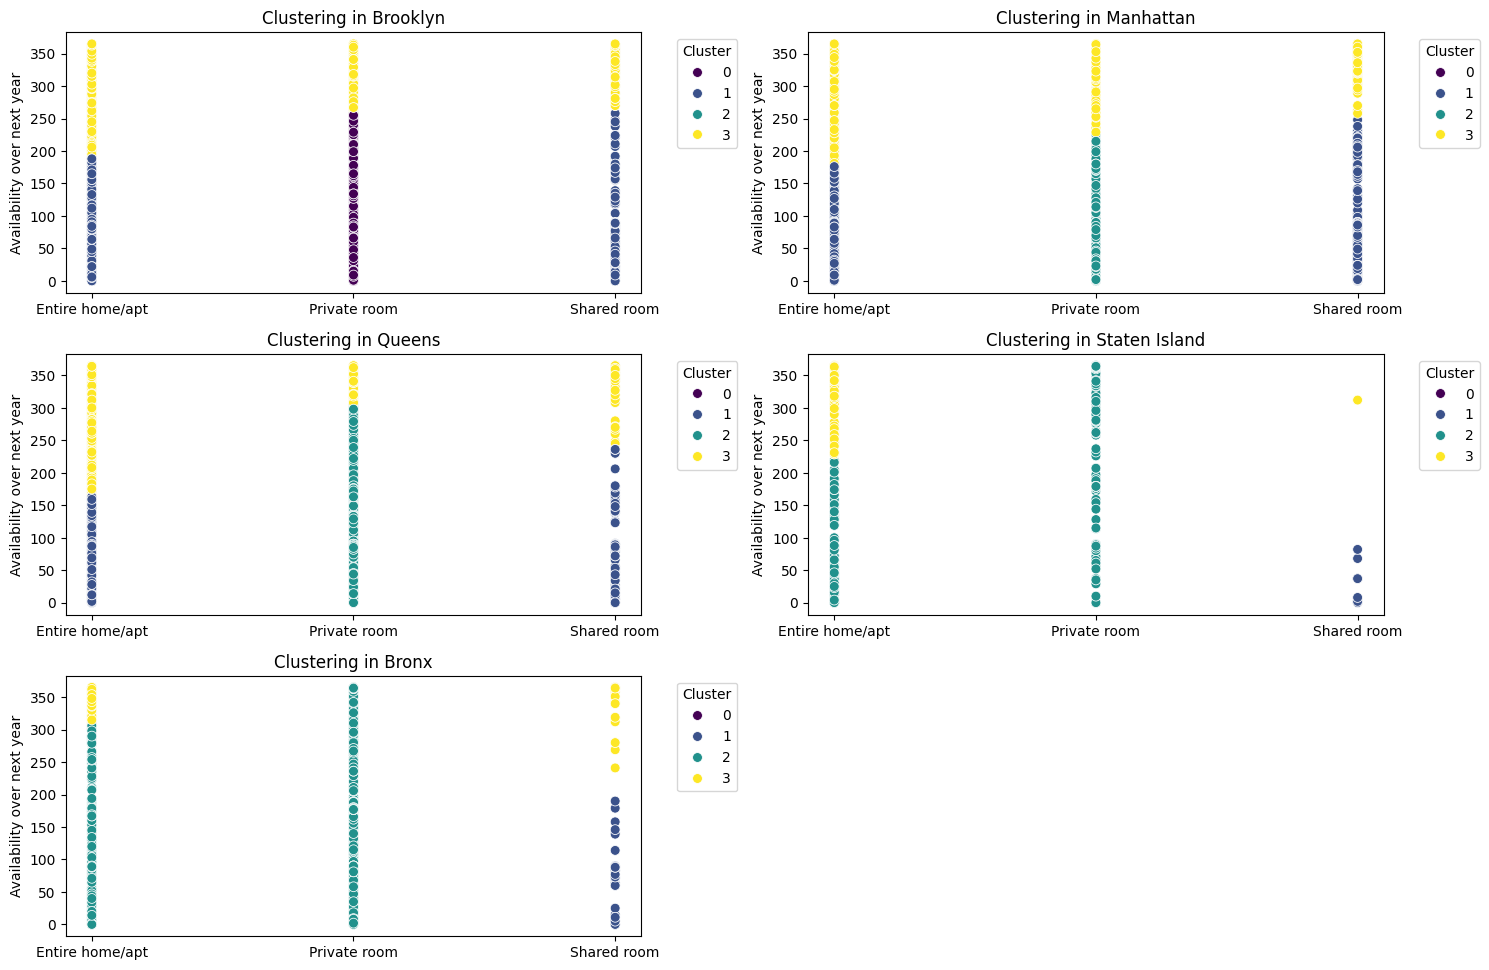

In [ ]:
# Set up the figure to create a grid
plt.figure(figsize = (15, 10))

# Define a consistent color palette for clusters as a list
cluster_colors = ["#440154", "#3b528b", "#21918c", "#fde725"]

# Define hue_order to ensure color consistency across all plots
hue_order = [0, 1, 2, 3]

# Separate plots by neighbourhood_group for better comparison
for i, group in enumerate(ab_nyc_df_analysis_cluster["neighbourhood_group_label"].unique(), 1):
  # Arrange in a grid with 2 columns
  plt.subplot(len(ab_nyc_df_analysis_cluster["neighbourhood_group_label"].unique()) // 2 + 1, 2, i)
  subset = ab_nyc_df_analysis_cluster[ab_nyc_df_analysis_cluster["neighbourhood_group_label"] == group]
  sns.scatterplot(
    data = subset,
    x = "room_type_label",
    y = "availability_365",
    hue = "cluster",
    palette = cluster_colors,
    hue_order = hue_order,
    s = 50
  )

  plt.tight_layout()
  plt.title(f"Clustering in {group}")
  plt.ylabel("Availability over next year")

  # Remove the x label
  plt.xlabel("")

  plt.legend(title = "Cluster", bbox_to_anchor = (1.05, 1), loc = "upper left")

This analysis suggests that Brooklyn and Queens tend to have the highest demand for shared rooms and private rooms, while Staten Island and the Bronx generally have lower demand, particularly for entire homes. Manhattan shows a mixed pattern, with higher availability for entire homes, possibly due to higher prices.

### Third business question: what is the distribution of listings between hosts and property types?
---
As observed in the data, Manhattan and Brooklyn tend to have a higher frequency of bookings and also command higher prices compared to other boroughs. This trend indicates a strong demand in these areas, likely due to their central locations and proximity to major attractions and business centers. In contrast, the Bronx and Staten Island exhibit much higher availability, suggesting they are less popular among renters. This disparity in availability and demand may be influenced by factors such as neighborhood appeal, convenience, and price sensitivity among renters.

In [ ]:
# Step 1: define host type by counting listings per host
host_counts = ab_nyc_df["host_id"].value_counts()
ab_nyc_df["host_type"] = ab_nyc_df["host_id"].apply(lambda x: "Individual" if host_counts[x] == 1 else "Commercial")

# Step 2: calculate distribution of listings by host type
host_type_distribution = ab_nyc_df["host_type"].value_counts(normalize = True) * 100

print("Distribution of listings by host type:")
print(host_type_distribution)

# Step 3: Calculate Distribution of Listings by Property Type
property_type_distribution = ab_nyc_df["room_type"].value_counts(normalize=True) * 100
print("\nDistribution of listings by property type:")
print(property_type_distribution)

# Step 4: Cross Distribution of Host Type and Property Type
cross_distribution = ab_nyc_df.groupby(["host_type", "room_type"]).size().unstack().fillna(0)
cross_distribution_percent = cross_distribution.div(cross_distribution.sum(axis=1), axis=0) * 100

print("\nDistribution of listings by host Type and property type:")
print(cross_distribution_percent)

Distribution of listings by host type:
host_type
Individual    66.06606
Commercial    33.93394
Name: proportion, dtype: float64

Distribution of listings by property type:
room_type
Entire home/apt    51.966459
Private room       45.661111
Shared room         2.372431
Name: proportion, dtype: float64

Distribution of listings by host Type and property type:
room_type   Entire home/apt  Private room  Shared room
host_type                                             
Commercial        38.651157     57.015429     4.333414
Individual        58.805684     39.829118     1.365198


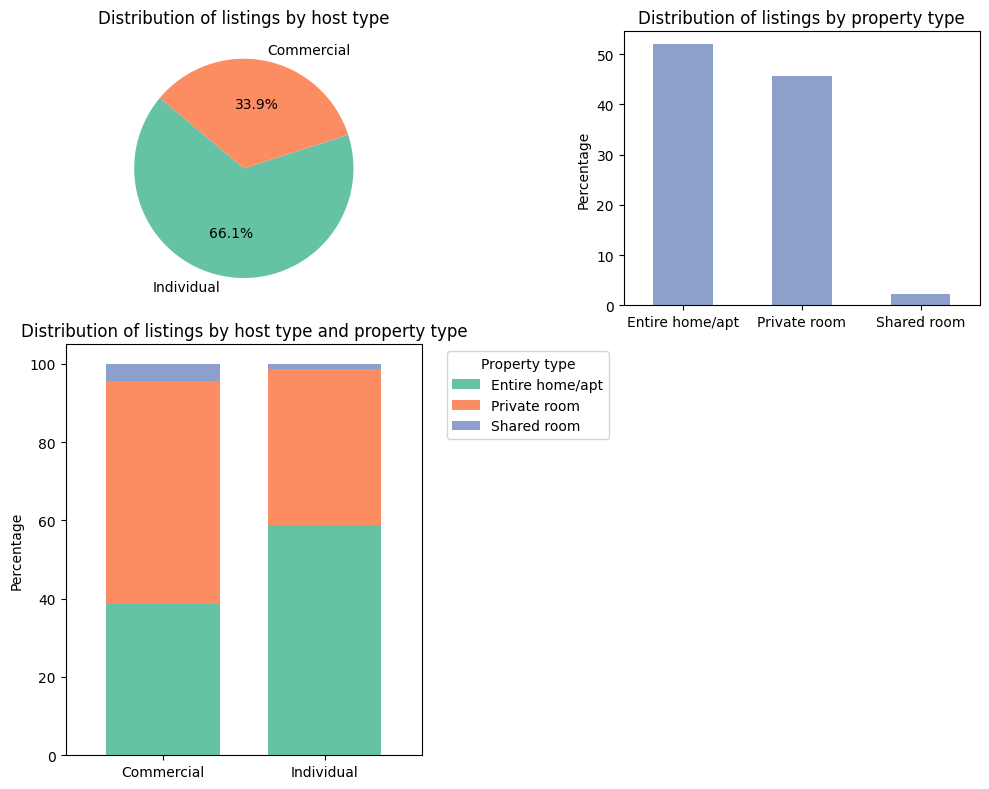

In [ ]:
# Set up the figure for two rows of subplots
fig, axes = plt.subplots(2, 2, figsize = (10, 8), gridspec_kw = {"height_ratios": [1, 1.5]})

# Plot 1: Host Type Distribution (Pie Chart)
host_type_distribution.plot(
  kind = "pie",
  autopct = "%1.1f%%",
  startangle = 140,
  colors = ["#66c2a5", "#fc8d62"],
  ax = axes[0, 0]
)
axes[0, 0].set_title("Distribution of listings by host type")
axes[0, 0].set_ylabel("")  # remove y-label for pie chart

# Plot 2: property type distribution (bar chart)
property_type_distribution.plot(
  kind = "bar",
  color = "#8da0cb",
  ax = axes[0, 1]
)
axes[0, 1].set_title("Distribution of listings by property type")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("Percentage")
axes[0, 1].tick_params(axis = 'x', rotation = 0)

# Plot 3: cross distribution of host type and property type (stacked bar chart)
cross_distribution_percent.plot(
  kind = "bar",
  stacked = True,
  color = ["#66c2a5", "#fc8d62", "#8da0cb"],
  width = 0.7,
  ax = axes[1, 0]
)
axes[1, 0].set_title("Distribution of listings by host type and property type")
axes[1, 0].set_xlabel("")
axes[1, 0].set_ylabel("Percentage")
axes[1, 0].legend(title = "Property type", bbox_to_anchor = (1.05, 1), loc = "upper left")
axes[1, 0].tick_params(axis = 'x', rotation = 0)

# Hide the empty subplot
axes[1, 1].axis("off")

# Adjust layout to prevent overlap
plt.tight_layout()

In our analysis, we found that that individual hosts manage the majority of listings (66.1%), while commercial hosts account for about one-third. Among property types, entire homes/apartments and private rooms dominate, with shared rooms being rare. The analysis shows that individual hosts are more inclined to offer entire homes, whereas commercial hosts provide a mix of entire homes and private rooms. Overall, the data suggests a strong preference among guests for private accommodations, as indicated by the high availability of entire homes and private rooms, with limited listings for shared rooms.